In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import os
import sys
import pandas as pd

cm_folder = "/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/notebooks/Causal Model/"
src_path = os.path.join(cm_folder, "src")
sys.path.append(src_path)

In [2]:
from typing import Any

import dill
import numpy as np

from CrossValidation import cross_validation
from structured_perceptron import StructuredPerceptron
from Settings import Settings

from window_based_tagger_config import get_config
from crel_helper import get_cr_tags
from crel_processing import essay_to_crels_cv
from evaluation import evaluate_model_essay_level, get_micro_metrics, metrics_to_df
from feature_normalization import min_max_normalize_feats
from function_helpers import get_function_names
from results_procesor import ResultsProcessor
from train_parser import essay_to_crels, create_extractor_functions
from cost_functions import micro_f1_cost_plusepsilon
from train_reranker import train_model, train_instance, get_essays_for_data, evaluate_ranker
from searn_parser_breadth_first import SearnModelBreadthFirst
from causal_model_features import CausalModelType
from feature_extraction import get_features_from_probabilities
from results_procesor import ResultsProcessor
from filter_features import filter_feats

from wordtagginghelper import merge_dictionaries
from results_procesor import ResultsProcessor, __MICRO_F1__
from evaluation import add_cr_labels

from random import shuffle
from joblib import Parallel, delayed
from collections import defaultdict

In [3]:
# Global settings
settings = Settings()
# CAUSAL_MODEL_TYPE = CausalModelType.CORAL_BLEACHING
CAUSAL_MODEL_TYPE = CausalModelType.SKIN_CANCER
root = "/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/notebooks/Causal Model/Re-Ranker Final Scripts"


Results Dir: /Users/simon.hughes/Google Drive/Phd/Results/
Data Dir:    /Users/simon.hughes/Google Drive/Phd/Data/
Root Dir:    /Users/SXH1M01/GitHub/NlpResearch/
Public Data: /Users/SXH1M01/GitHub/NlpResearch/Data/PublicDatasets/


In [4]:
# Global settings
CM_NAME = ""
if CAUSAL_MODEL_TYPE == CausalModelType.CORAL_BLEACHING:
    CM_NAME = "Coral Bleaching"
    root_folder = settings.data_directory + "CoralBleaching/Thesis_Dataset/"
    training_folder = root_folder + "Training" + "/"
    test_folder = root_folder + "Test" + "/"

    crels_folder = root + "/crels/CB"
    coref_root = root_folder + "CoReference/"
    coref_output_folder = coref_root + "CRel/"

    # first and second were with initial_weight set to 1.0
    # thrid is with set to 0.001

    config = get_config(training_folder)
    
    train_fname = coref_output_folder + "training_crel_anatagged_essays_most_recent_code.dill"
    with open(train_fname, "rb") as f:
        pred_tagged_essays_train = dill.load(f)

    test_fname = coref_output_folder + "test_crel_anatagged_essays_most_recent_code.dill"
    with open(test_fname, "rb") as f:
        pred_tagged_essays_test = dill.load(f)

else: # SC
    CM_NAME = "Skin Cancer"
    root_folder = settings.data_directory + "SkinCancer/Thesis_Dataset/"
    training_folder = root_folder + "Training" + "/"
    test_folder = root_folder + "Test" + "/"

    crels_folder = root + "/crels/SC"
    coref_root = root_folder + "CoReference/"
    coref_output_folder = coref_root + "CRel/"

    MONGO_COLLECTION = "SC_STR_PCPTRN_RE-RANKER_HYPER_PARAM_TD"
    MONGO_TEST_COLLECTION = "TEST_SC_STR_PCPTRN_RE-RANKER_TD"

    config = get_config(training_folder)
    
    train_fname = coref_output_folder + "training_crel_anatagged_essays_most_recent_code.dill"
    with open(train_fname, "rb") as f:
        pred_tagged_essays_train = dill.load(f)

    test_fname = coref_output_folder + "test_crel_anatagged_essays_most_recent_code.dill"
    with open(test_fname, "rb") as f:
        pred_tagged_essays_test = dill.load(f)

print(len(pred_tagged_essays_train), len(pred_tagged_essays_test), CM_NAME)

870 218 Skin Cancer


In [5]:
cr_tags = get_cr_tags(train_tagged_essays=pred_tagged_essays_train, tag_essays_test=pred_tagged_essays_test)

set_cr_tags = set(cr_tags)
print(len(cr_tags))

52


In [6]:
all_essays = pred_tagged_essays_train + pred_tagged_essays_test
name2essay = {}
for essay in all_essays:
    name2essay[essay.name] = essay

name2crels = essay_to_crels(all_essays, set_cr_tags)
assert len(name2crels) == len(all_essays)

In [7]:
len(all_essays)

1088

In [8]:
c_lens = []
for name, crels in name2crels.items():
#     print(len(crels))
    if crels:
        c_lens.append(len(crels))
np.mean(c_lens), len(name2crels)

(4.99794026776519, 1088)

In [9]:
crels_folder

'/Users/simon.hughes/GitHub/NlpResearch/PythonNlpResearch/notebooks/Causal Model/Re-Ranker Final Scripts/crels/SC'

In [10]:
def load_rerank(top_n):
    rr_fname = "xs_rerank_" + str(top_n) + ".dill"
    with open(os.path.join(crels_folder, rr_fname), "rb") as f:
        xs_rerank = dill.load(f)

    rr_fname = "xs_rerank_test" + str(top_n) + ".dill"
    with open(os.path.join(crels_folder, rr_fname), "rb") as f:
        xs_test_rerank = dill.load(f)
    return xs_rerank, xs_test_rerank

In [11]:
def get_actual_crels_counts():    
    lens = []
    # Dict[str,Set[str]]
    for ename, crels in name2crels.items():
        lens.append(len(crels))
    return lens

def get_predicted_crels_counts(top_n):
    # Td, Vd
    a,b = load_rerank(top_n=top_n)
    a.update(b)
    
    lens = []
    # Dict[str,Dict[str,List[float]]]
    for ename, dct in a.items():
        lens.append(len(dct.keys()))
    return lens

topn2lens = {}
for topn in [1,2,3,5,7,10]:
    topn2lens[topn] = get_predicted_crels_counts(topn)

In [12]:
DP = 4 # decimal points
cols = ["Beam Size", "Max.", "Mean",         
        "25%",
        "50%", "75%", 
        "90%", 
        "95%", 
#         "99%"
       ]

def list2stats(l, n):
    d = {
        "Beam Size": n,
        "Mean": np.mean(l),
        "Max.": np.max(l),
        "Min.": np.min(l),
        "25%": np.percentile(l,25),
        "50%": np.percentile(l,50),
        "75%": np.percentile(l,75),
        "90%": np.percentile(l,90),
        "95%": np.percentile(l,95),
        "98%": np.percentile(l,98),
        "99%": np.percentile(l,99),
    }
    return d
        
def df2latex_table(df, columns=None, dp=3):
    # print header
    if columns is None:
        columns = list(df.columns)
    s_col_def = "\\begin{tabular}{" + ("c " * len(columns)) + "}\n"
    s_col_def += "  \\toprule\n"
    s = s_col_def
    for col in columns:
        s += "\\textbf{{ {col} }} & ".format(col=col.replace("%", "\\%"))
    print(s[:-2] + " \\\\")
    print("\\midrule")
    del s
    
    # print rows
    for i,row in df.iterrows():
        s = ""
        for col in columns:
            oval = row[col]
            if type(oval) == str or oval is None:
                val = "Human Labels"
            else:
                v = round(oval,dp)
                ival = int(oval)
                if v == ival:
                    val = str(int(v))
                else:
                    fmt = "{val:." + str(dp) + "f}"
                    val = fmt.format(val=oval)
            s += val + " & "
        print(s[:-2].strip() + " \\\\")
    print("\\bottomrule")
    print("\\end{tabular}}")
        
l = get_actual_crels_counts()
df = pd.DataFrame([list2stats(l, "-")])[cols]

df2latex_table(df)
df

\begin{tabular}{c c c c c c c c }
  \toprule
\textbf{ Beam Size } & \textbf{ Max. } & \textbf{ Mean } & \textbf{ 25\% } & \textbf{ 50\% } & \textbf{ 75\% } & \textbf{ 90\% } & \textbf{ 95\% }  \\
\midrule
Human Labels & 15 & 4.460 & 2 & 4 & 6 & 8 & 10 \\
\bottomrule
\end{tabular}}


,Beam Size,Max.,Mean,25%,50%,75%,90%,95%
0,-,15,4.460478,2.0,4.0,6.0,8.0,10.0


## Plot Histogram

In [13]:
import matplotlib.pyplot as plt
# import seaborn as sns
ncrels = l

In [14]:
cm_abbrev = "".join([chars[0] for chars in CM_NAME.lower().split(" ")])
cm_abbrev

'sc'

In [15]:
# plt.figure(figsize=(12, 6))
# ax = sns.distplot(ncrels, bins=max(ncrels), kde=False)
# ax.set_ylabel("Number of Essays")
# ax.set_xlabel("Number of Causal Relations Per Essay")
# plt.savefig(f"/Users/simon.hughes/BitBucket/dissertation/Dissertation/images/rq4_crels_per_essay_{cm_abbrev}.png")

In [16]:
def setup_histogram(counts, xlabel):
    ninety_five_pct = np.percentile(counts,95.0)
    nbins = max(counts)

    plt.figure(figsize=(12, 6))
    N, bins, patches = plt.hist(x=counts, bins=nbins, 
                                alpha=0.6, histtype='bar', ec='black',
    #                             cumulative=True, normed=True
                                cumulative=False, normed=False
                               )

    for nrels, p in zip(bins, patches):
        if nrels < ninety_five_pct:
            plt.setp(p, 'facecolor', 'darkblue')
        else:
            plt.setp(p, 'facecolor', 'lightblue')

    plt.xlabel(xlabel, fontsize=16)  
    plt.ylabel("Percentage of Essays", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # Set number of ticks
    plt.locator_params(axis='x', nbins=nbins)
    plt.xlim(0, nbins)
    ax = plt.subplot(111)
    return ax, N

In [17]:
max_yval = 0

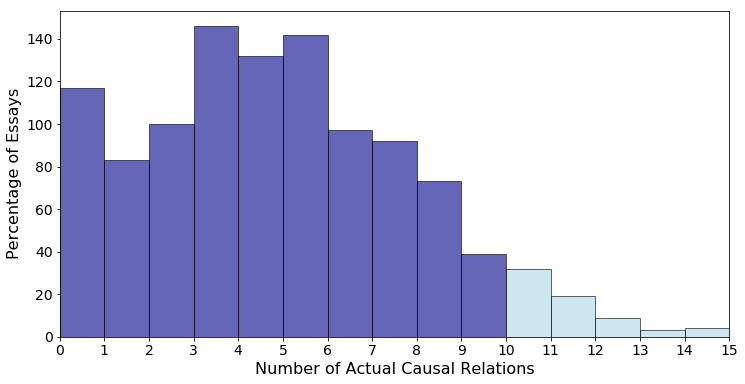

In [18]:
counts = get_actual_crels_counts()
ax, yvals = setup_histogram(counts, xlabel="Number of Actual Causal Relations")
max_yval = max(max_yval, max(yvals))
plt.show()

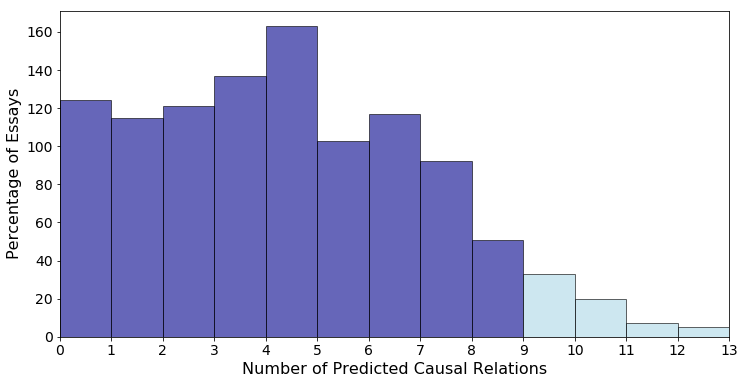

In [19]:
counts = get_predicted_crels_counts(top_n=1)
ax, yvals = setup_histogram(counts, xlabel="Number of Predicted Causal Relations")
max_yval = max(max_yval, max(yvals))
plt.show()

In [20]:
max_yval

163.0

In [21]:
import matplotlib.ticker as plticker

FONT_SIZE = 14
def setup_hist_subplot(counts, ax, color, lbl):
    
    ninety_five_pct = np.percentile(counts,95.0)

    bins = np.arange(max(counts)) - 0.5
    N, hbins, patches = ax.hist(x=counts, bins=bins, 
                                alpha=0.5, histtype='bar', ec='black',
    #                             cumulative=True, normed=True
                                color=color, label=lbl,
                                cumulative=False, normed=False)

    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    ax.legend(loc='upper right',fontsize = FONT_SIZE)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FONT_SIZE) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(FONT_SIZE) 

In [22]:
# max(max(human_cnts), max(pred_cnts))

## Try Stacked Histograms

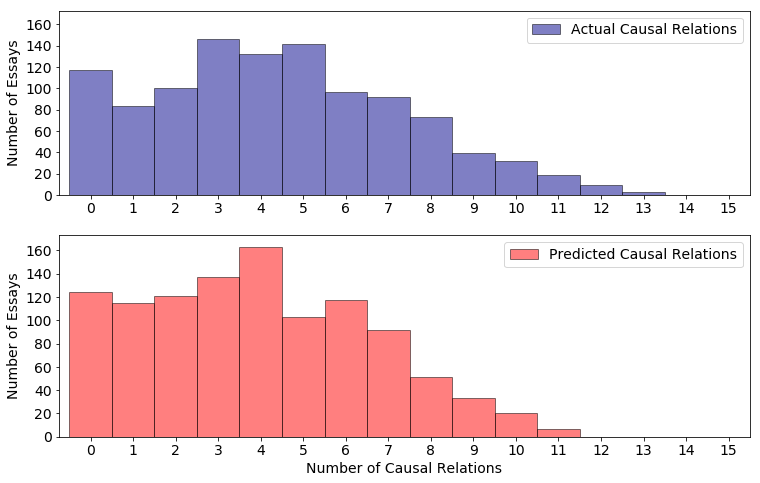

In [23]:
fig = plt.figure(figsize=(12,8))
ylim=(0, max_yval+10)

# Get counts
human_cnts = get_actual_crels_counts()
pred_cnts  = get_predicted_crels_counts(top_n=1)

nbins = max(max(human_cnts), max(pred_cnts)) + 1
xlim = (-0.75, nbins-0.5)
# Setup axes

ax1 = fig.add_axes([0.1, 0.52, 0.8, 0.32], xlim=xlim, ylim=ylim)
# f, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, squeeze=True)
# f.set_figwidth(12)
# f.set_figheight(8)

# ax1.set_xlabel("Number of Actual Causal Relations", fontsize = FONT_SIZE) #
ax1.set_ylabel("Number of Essays", fontsize = FONT_SIZE) #

ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.35], xlim=xlim, ylim=ylim)
ax2.set_xlabel("Number of Causal Relations", fontsize = FONT_SIZE) #
ax2.set_ylabel("Number of Essays", fontsize = FONT_SIZE) #
# ax2.locator_params(axis='x', nbins=max(pred_cnts))

setup_hist_subplot(human_cnts, ax1, color="darkblue", lbl="Actual Causal Relations")
setup_hist_subplot(pred_cnts,  ax2, color="red", lbl="Predicted Causal Relations")

# fname = f"{images_folder}/rq4_crels_per_essay_{cm_abbrev}.png"
# plt.savefig(fname, bbox_inches = 'tight', pad_inches = 0) # remove unneccessary whitespace

In [24]:
def set_tick_font_size(ax, fs):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fs) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fs) 

## Create Side by Side Bar Charts

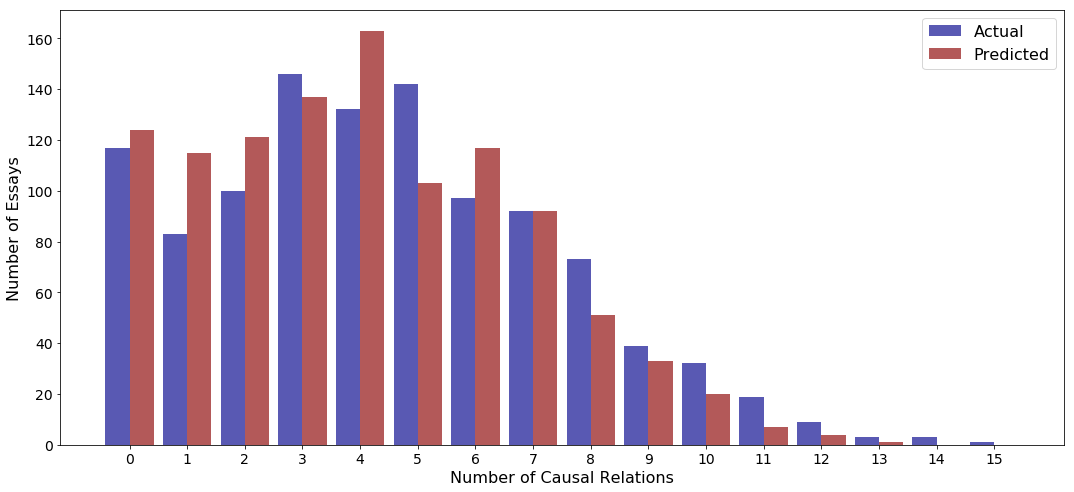

In [26]:
from collections import Counter

FONT_SIZE = 16

human_cnts = get_actual_crels_counts()
pred_cnts  = get_predicted_crels_counts(top_n=1)

max_val = max(max(human_cnts), max(pred_cnts))
ind = np.arange(0,max_val+1)  # the x locations for the groups

def get_bar_heights(lens, inds): # get the bins
    cnt = Counter(lens)
    bins = []
    for i in inds:
        if i in cnt:
            bins.append(cnt[i])
        else:
            bins.append(0)
    return bins

# ind = np.arange(N)
width = 0.42       # the width of the bars

fig = plt.figure()
fig.set_figwidth(18)
fig.set_figheight(8)

ax = fig.add_subplot(111)

human_nessays = get_bar_heights(human_cnts, ind)
rects1 = ax.bar(ind,       human_nessays, width, alpha=0.65, color='darkblue')

pred_nessays = get_bar_heights(pred_cnts, ind)
rects2 = ax.bar(ind+width, pred_nessays,  width, alpha=0.65, color='darkred')

# add some
ax.set_xlabel('Number of Causal Relations', fontsize=FONT_SIZE)
ax.set_ylabel('Number of Essays',           fontsize=FONT_SIZE)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ind  )
set_tick_font_size(ax, FONT_SIZE-2)
ax.legend( (rects1[0], rects2[0]), ('Actual', 'Predicted'), fontsize=FONT_SIZE)

# plt.show()

images_folder = "/Users/simon.hughes/BitBucket/dissertation/Dissertation/images"

fname = f"{images_folder}/rq4_crels_per_essay_{cm_abbrev}.png"
plt.savefig(fname, bbox_inches = 'tight', pad_inches = 0) # remove unneccessary whitespace

## Actual Crels

In [ ]:
l = get_actual_crels_counts()
df = pd.DataFrame([list2stats(l, "-")])[cols]

df2latex_table(df, dp=DP)
df

## Predicted Crels

In [24]:
dicts = []
for n, l in topn2lens.items():    
    dicts.append(list2stats(l, n))
df_stats = pd.DataFrame(dicts)[cols]

df2latex_table(df_stats)

df_stats

\begin{tabular}{c c c c c c c c }
  \toprule
\textbf{ Beam Size } & \textbf{ Max. } & \textbf{ Mean } & \textbf{ 25\% } & \textbf{ 50\% } & \textbf{ 75\% } & \textbf{ 90\% } & \textbf{ 95\% }  \\
\midrule
1 & 13 & 3.974 & 2 & 4 & 6 & 8 & 9 \\
2 & 13 & 3.975 & 2 & 4 & 6 & 8 & 9 \\
3 & 15 & 4.811 & 2 & 5 & 7 & 9 & 11 \\
5 & 25 & 7.747 & 4 & 7 & 11 & 15 & 17 \\
7 & 25 & 7.747 & 4 & 7 & 11 & 15 & 17 \\
10 & 25 & 7.747 & 4 & 7 & 11 & 15 & 17 \\
\bottomrule
\end{tabular}}


,Beam Size,Max.,Mean,25%,50%,75%,90%,95%
0,1,13,3.974265,2.0,4.0,6.0,8.0,9.0
1,2,13,3.975184,2.0,4.0,6.0,8.0,9.0
2,3,15,4.810662,2.0,5.0,7.0,9.0,11.0
3,5,25,7.747243,4.0,7.0,11.0,15.0,17.0
4,7,25,7.747243,4.0,7.0,11.0,15.0,17.0
5,10,25,7.747243,4.0,7.0,11.0,15.0,17.0


In [14]:
# df.columns

In [15]:
# df2latex_table(df)

## Differences by Top N?

In [17]:
# Are the counts different?
# CB: 5 and 10, yes, marginally. 7 and 10 - Nope
# SC: 1-3 and 5 diff, 5, 7 and 10 are the same

# for i, (a,b) in enumerate(zip(topn2lens[3],topn2lens[5])):
#     if a != b:
#         print(i,a,b)

for i, (a,b) in enumerate(zip(topn2lens[5],topn2lens[7])):
    if a != b:
        print(i,a,b)
print("." * 10)
for i, (a,b) in enumerate(zip(topn2lens[7],topn2lens[10])):
    if a != b:
        print(i,a,b)

401 3 4
503 5 6
551 2 3
585 12 13
806 5 6
996 7 8
..........


In [18]:
import pymongo

client = pymongo.MongoClient(serverSelectionTimeoutMS=100, host="127.0.0.1")
db = client.metrics_causal_model_reranker

In [19]:
import datetime

def query_params_for(db, collection):
    project = {
            "params": "$parameters",
            "micro_f1": "$MICRO_F1",
            "asof": "$asof",
            "_id": 1
        }
    feats_pipeline = [{ "$project": project }]
    return [row for row in db[collection].aggregate(feats_pipeline)]    

def get_df(collection):
    rows = query_params_for(db=client.metrics_causal_model_reranker, collection=collection)   
    if len(rows) == 0:
        return pd.DataFrame([])

    results = []
    for r in rows:
        d = dict(r["params"])
        d.update(r["micro_f1"])
        d["asof"] = str(r["asof"])
        results.append(d)
    
    df = pd.DataFrame(results)
    df["extractors"] = df["extractors"].apply(lambda l: ",".join(l))
    df = df.sort_values(by="f1_score",ascending=False)
    cols = ["f1_score", "precision", "recall", "asof","best_top_n"]
    return df[cols]

In [20]:
CAUSAL_MODEL_TYPE

'CoralBleaching'

In [21]:
if CAUSAL_MODEL_TYPE == CausalModelType.CORAL_BLEACHING:
    collection = "CB_STR_PCPTRN_RE-RANKER_HYPER_PARAM_VD"
elif CAUSAL_MODEL_TYPE == CausalModelType.SKIN_CANCER:
    collection = "SC_STR_PCPTRN_RE-RANKER_HYPER_PARAM_VD_3"
else:
    raise Exception()
    
df = get_df(collection).copy(deep=True)
df.head()

,f1_score,precision,recall,asof,best_top_n
29,0.741353,0.782873,0.704015,2019-06-24 20:43:02.777000,1
4,0.740970,0.787033,0.700000,2019-06-24 19:41:12.771000,2
27,0.740081,0.787804,0.697810,2019-06-24 20:40:56.262000,1
5,0.740054,0.785890,0.699270,2019-06-24 19:42:20.087000,2
6,0.739954,0.786125,0.698905,2019-06-24 19:43:32.740000,2


In [23]:
top_rows = []
for n in sorted(df.best_top_n.unique()):
    sub = df[df.best_top_n == n].head(1).copy(deep=True)
    top_rows.append(sub)

df_by_bs = pd.concat(top_rows)[["best_top_n","f1_score", "recall", "precision"]]
df_by_bs["Beam Size"] = df_by_bs["best_top_n"]
del df_by_bs["best_top_n"]
df_by_bs

,f1_score,recall,precision,Beam Size
29,0.741353,0.704015,0.782873,1
4,0.740970,0.700000,0.787033,2
11,0.739610,0.698175,0.786272,3
18,0.739231,0.701460,0.781301,5
37,0.739139,0.698540,0.784748,7
46,0.738284,0.698540,0.782822,10


In [24]:
# pd.merge?

In [26]:
merged = pd.merge(df_stats, df_by_bs, on = "Beam Size")
df2latex_table(merged, dp=4)
merged

\begin{tabular}{c c c c c c }
  \toprule
\textbf{ Beam Size } & \textbf{ Max. } & \textbf{ Mean } & \textbf{ f1_score } & \textbf{ recall } & \textbf{ precision }  \\
\midrule
1 & 13 & 2.9583 & 0.7414 & 0.7040 & 0.7829 \\
2 & 13 & 2.9663 & 0.7410 & 0.7000 & 0.7870 \\
3 & 15 & 3.6427 & 0.7396 & 0.6982 & 0.7863 \\
5 & 22 & 5.3528 & 0.7392 & 0.7015 & 0.7813 \\
7 & 22 & 5.3582 & 0.7391 & 0.6985 & 0.7847 \\
10 & 22 & 5.3582 & 0.7383 & 0.6985 & 0.7828 \\
\bottomrule
\end{tabular}}


,Beam Size,Max.,Mean,f1_score,recall,precision
0,1,13,2.958333,0.741353,0.704015,0.782873
1,2,13,2.966312,0.740970,0.700000,0.787033
2,3,15,3.642730,0.739610,0.698175,0.786272
3,5,22,5.352837,0.739231,0.701460,0.781301
4,7,22,5.358156,0.739139,0.698540,0.784748
5,10,22,5.358156,0.738284,0.698540,0.782822


In [48]:
from collections import defaultdict
from build_chains import build_chains

ename2chain = {}
for ename, crels in name2crels.items():
    if len(crels) >= 2:
        tree = defaultdict(set)
        for crel in crels:
            l,r = crel.replace("Causer:","").replace("Result:","").split("->")
            tree[l].add(r)
        chains = build_chains(tree)
        if chains:
            longest = sorted(chains, key = lambda ch: -len(ch))[0]
            ename2chain[ename] = longest

sorted(ename2chain.items(), key = lambda tpl: -len(tpl[1]))[0:5]

[('EBA1415_SDLC_6_CB_ES-04749.ann', ['12', '13', '6', '7', '1', '3', '50']),
 ('EBA1415_BLHT_5_CB_ES-05205.ann', ['1', '2', '3', '4', '5', '50']),
 ('EBA1415_LZBA_4_CB_ES-05530.ann', ['1', '2', '3', '4', '5', '5b']),
 ('EBA1415_SDMK_6_CB_ES-04773.ann', ['11', '13', '4', '5b', '7', '50']),
 ('EBA1415_SEKL_2_CB-04829.ann', ['1', '3', '4', '5', '7', '50'])]

In [49]:
top_chains = dict(((k,v) for k,v in ename2chain.items() if len(v) >= 6))

In [55]:
for ename in top_chains.keys():
    print(ename.ljust(40), "\t", len(name2crels[ename]), "\t", top_chains[ename])

EBA1415_BLHT_5_CB_ES-05205.ann           	 10 	 ['1', '2', '3', '4', '5', '50']
EBA1415_LZBA_4_CB_ES-05530.ann           	 15 	 ['1', '2', '3', '4', '5', '5b']
EBA1415_SDMK_6_CB_ES-04773.ann           	 12 	 ['11', '13', '4', '5b', '7', '50']
EBA1415_SEKL_2_CB-04829.ann              	 6 	 ['1', '3', '4', '5', '7', '50']
EBA1415_SERS_1314_CB_ES-05098.ann        	 12 	 ['1', '3', '4', '14', '11', '13']
EBA1415_TFHC_4_CB_ES-05828.ann           	 10 	 ['1', '3', '4', '6', '7', '50']
EBA1415_TRKM_2_CB_ES-6048.ann            	 8 	 ['1', '3', '4', '5', '7', '50']
EBA1415post_TWNB_3_CB_ES-04984.ann       	 10 	 ['1', '2', '3', '4', '5', '5b']
EBA1415_SDLC_6_CB_ES-04749.ann           	 9 	 ['12', '13', '6', '7', '1', '3', '50']


In [70]:
e = [e for e in pred_tagged_essays_train if e.name =="EBA1415_SEKL_2_CB-04829.ann" ][0]
for sent in e.sentences:
    wds,tags = list(zip(*sent))
    print(" ".join(wds))
    cr = set()
    for t in tags:
        crels = [c for c in t if "->" in c and "Anaphor" not in c]
        cr.update(crels)
    if cr:
        print(sorted(cr))

coral bleaching can occur when there is a strong enviromental change for coral .
as water temperature increases , carbon dioxide decreases .
['Causer:3->Result:4']
coral is very sensitive to the amount of salt in the ocean water .
since the algae provides coral with color , if the algae dies due to enviromental changes , the coral will lose its color .
['Causer:7->Result:50']
the algae could die form the constant temperature changes due to the many shifting trade winds .
['Causer:1->Result:3', 'Causer:3->Result:7']
the trade winds cause temperature to rise .
['Causer:1->Result:3']
that lowers the carbon dioxide that the algae needs to survive .
['Causer:3->Result:4']
without the carbon dioxide , algae cant feed itself using the INFREQUENT of photosynthesis .
['Causer:4->Result:5']
that causes the algae to die therefore , resulting in coral bleaching .
['Causer:5->Result:7', 'Causer:7->Result:50']


In [85]:
"as ".ljust(5)

'as   '

In [86]:
e = [e for e in pred_tagged_essays_train if e.name =="EBA1415_SEKL_2_CB-04829.ann" ][0]

for sent in e.sentences:
    
    pwds, pcrels = "",""
    for wd, tags in sent:
        wd = wd.strip()
        crels = [t for t in tags if "->" in t and "Anaphor" not in t]
        s_crels = "|".join(sorted(crels)).replace("Causer:","C").replace("Result:","")
        pad = max(len(s_crels), len(wd)) + 1
        pwds   += wd.ljust(pad, " ")
        pcrels += s_crels.ljust(pad, " ")
        
    print(pwds)
    if pcrels.strip():
        print(pcrels.strip())
    print()

coral bleaching can occur when there is a strong enviromental change for coral . 

as water temperature increases , carbon dioxide decreases . 
C3->4 C3->4       C3->4       C3->4  C3->4   C3->4

coral is very sensitive to the amount of salt in the ocean water . 

since the algae provides coral with color , if the algae  dies   due    to     enviromental changes , the    coral  will   lose   its    color  . 
C7->50 C7->50 C7->50 C7->50 C7->50       C7->50    C7->50 C7->50 C7->50 C7->50 C7->50 C7->50

the algae could die   form  the   constant    temperature changes     due   to    the   many  shifting trade winds . 
C3->7 C3->7 C3->7 C3->7 C3->7 C1->3|C3->7 C1->3|C3->7 C1->3|C3->7 C1->3 C1->3 C1->3 C1->3 C1->3    C1->3 C1->3

the   trade winds cause temperature to    rise  . 
C1->3 C1->3 C1->3 C1->3 C1->3       C1->3 C1->3

that  lowers the   carbon dioxide that the algae needs to survive . 
C3->4 C3->4  C3->4 C3->4  C3->4

without the   carbon dioxide , algae cant  feed  itself using 

In [95]:
e = [e for e in pred_tagged_essays_train if e.name =="EBA1415_SEKL_2_CB-04829.ann" ][0]

for sent in e.sentences:
    
    pwds, pcrels = "",""
    for wd, tags in sent:
        wd = wd.strip()
        crels = [t for t in tags if "->" in t and "Anaphor" not in t]
        s_ccodes = "|".join(sorted([t for t in tags if t[0].isdigit() and "->" not in t]))
        s_crels = "|".join(sorted(crels)).replace("Causer:","").replace("Result:","")
        print(wd.ljust(20), s_ccodes.ljust(5), s_crels)
        
    print("-" * 80)

coral                50    
bleaching            50    
can                        
occur                      
when                       
there                      
is                         
a                          
strong                     
enviromental               
change                     
for                        
coral                      
.                          
--------------------------------------------------------------------------------
as                         
water                3     3->4
temperature          3     3->4
increases            3     3->4
,                          
carbon               4     3->4
dioxide              4     3->4
decreases            4     3->4
.                          
--------------------------------------------------------------------------------
coral                      
is                         
very                       
sensitive            3     
to                   3     
the                  3     
am